Model loaded successfully!
Training samples: 63
Validation samples: 16


<ipython-input-8-f40958bd3973>:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


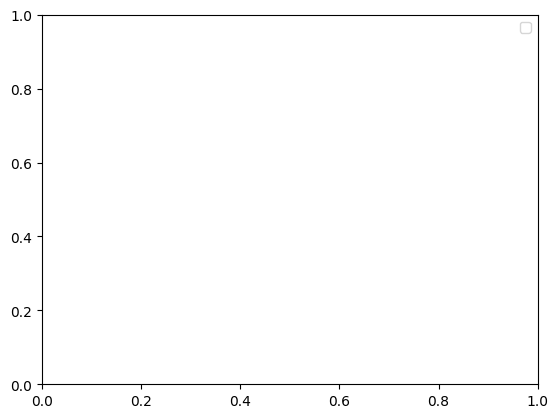

16/16 ━━━━━━━━━━━━━━━━━━━━ 190s 11s/step - accuracy: 0.1336 - loss: 3.2346 - sparse_top_k_categorical_accuracy: 0.5539
Test Results: [3.2567336559295654, 0.11999999731779099, 0.5400000214576721]
Test Accuracy: 0.11999999731779099


In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

# Load EuroSAT dataset (land use classification)
(ds_train, ds_test), ds_info = tfds.load(
    'eurosat/rgb', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True
)

# Preprocess function
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

ds_train = ds_train.map(format_image).take(1000).batch(16).shuffle(500)
ds_test = ds_test.map(format_image).take(250).batch(16)

# Ensure cache directory exists
os.environ["TFHUB_CACHE_DIR"] = "/tmp/tfhub_modules"

# Load Vision Transformer (ViT) from TensorFlow Hub
vit_model = hub.KerasLayer(
    "https://tfhub.dev/sayakpaul/vit_b16_fe/1", input_shape=(224, 224, 3), trainable=True
)

print("Model loaded successfully!")

# Build Model using Functional API
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(lambda img: vit_model(img), output_shape=(768,))(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),  # Lower LR for fine-tuning
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

train_samples = sum(1 for _ in ds_train)
val_samples = sum(1 for _ in ds_test)
print(f'Training samples: {train_samples}')
print(f'Validation samples: {val_samples}')
if train_samples == 0 or val_samples == 0:
    raise RuntimeError('No valid training/validation samples found!')
plt.legend()
plt.show()

# Evaluate on test set
results = model.evaluate(ds_test)
print("Test Results:", results)
print("Test Accuracy:", results[1])
